## **Data Load and Build train/test dataset**

In [2]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


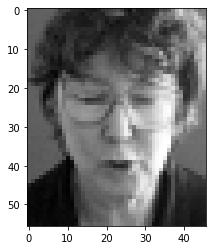

In [26]:
plt.imshow(np.reshape(x_train[:,0],(46,56)).T, cmap = 'gist_gray')

## **Q1. [10] Eigenfaces**

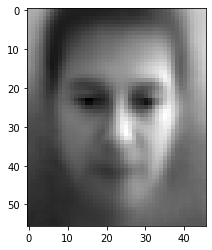

In [27]:
# Get train_mean
x_train_bar = np.average(x_train, axis=1).reshape(-1,1)
# show mean image
plt.imshow(np.reshape(x_train_bar,(46,56)).T, cmap = 'gist_gray')

In [7]:
# Subtract the mean face
A = x_train - x_train_bar

# S_a = (1/N)AA^T
S_a = np.matmul(A, A.T) / A.shape[1]

# S_b = (1/N)A^TA
S_b = np.matmul(A.T, A) / A.shape[1]

In [9]:
# S_a eigendecomposition
eigvals_a, eigvecs_a = np.linalg.eigh(S_a)

sorted_indices = np.argsort(eigvals_a)[::-1]

eigvals_a = eigvals_a[sorted_indices]
eigvecs_a = eigvecs_a[:, sorted_indices]

# S_b eigendecomposition
eigvals_b, eigvecs_b = np.linalg.eigh(S_b)

sorted_indices = np.argsort(eigvals_b)[::-1]

eigvals_b = eigvals_b[sorted_indices]
eigvecs_b = eigvecs_b[:, sorted_indices]

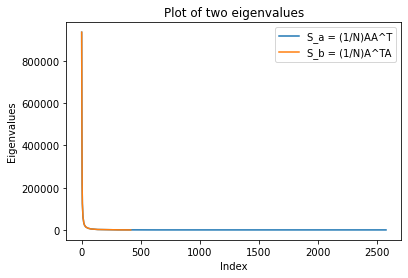

In [10]:
# Plot the arrays
plt.plot(eigvals_a, label="S_a = (1/N)AA^T")
plt.plot(eigvals_b, label="S_b = (1/N)A^TA")

# Add title and labels
plt.title("Plot of two eigenvalues")
plt.xlabel("Index")
plt.ylabel("Eigenvalues")

# Add a legend to distinguish the arrays
plt.legend()

# Show the plot
plt.show()

## **Q1. [15] Application of Eigenfaces**

step 7: keep the best M eigenvectors

In [11]:
M = [5, 15, 30]

# Using S_a
U_0 = eigvecs_a[:, :M[0]]
U_1 = eigvecs_a[:, :M[1]]
U_2 = eigvecs_a[:, :M[2]]

step 8: get W = U^TA

In [12]:
W_0 = np.matmul(U_0.T, A)
W_1 = np.matmul(U_1.T, A)
W_2 = np.matmul(U_2.T, A)

Step9: reconstruction

In [13]:
x_rec_0 = x_train_bar + np.matmul(U_0, W_0)
x_rec_1 = x_train_bar + np.matmul(U_1, W_1)
x_rec_2 = x_train_bar + np.matmul(U_2, W_2)

Show reconstruction image

In [14]:
def recon_img(n):
    print(f'reconstruction with {M[0]} eigenvectors ')
    if n == 0:
        plt.imshow(np.reshape(x_rec_0[:,1],(46,56)).T, cmap = 'gist_gray')
    elif n == 1:
        plt.imshow(np.reshape(x_rec_1[:,1],(46,56)).T, cmap = 'gist_gray')
    elif n == 2:
        plt.imshow(np.reshape(x_rec_2[:,1],(46,56)).T, cmap = 'gist_gray')

reconstruction with 5 eigenvectors 


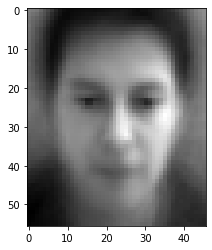

In [15]:
recon_img(0)

### **Reconstruction Error**

In [16]:
rec_err_0 = np.mean(np.abs(x_train - x_rec_0))
print(f"Reconstruction Error with {M[0]} eigenvectors (MAE): {rec_err_0}")

rec_err_1 = np.mean(np.abs(x_train - x_rec_1))
print(f"Reconstruction Error with {M[1]} eigenvectors (MAE): {rec_err_1}")

rec_err_2 = np.mean(np.abs(x_train - x_rec_2))
print(f"Reconstruction Error with {M[2]} eigenvectors (MAE): {rec_err_2}")

Reconstruction Error with 5 eigenvectors (MAE): 20.586167122477296
Reconstruction Error with 15 eigenvectors (MAE): 15.61619434362437
Reconstruction Error with 30 eigenvectors (MAE): 12.605747485982162


### **1. (b) PCA based face recognition**

앞에서 구했던 eigenvector 직접 사용 -> 최종 버전에서는 필요 없음!

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the 1-Nearest Neighbor classifier with L1 distance (Manhattan distance)
nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

# projection of training images
x_train_proj = np.matmul(U_0.T, x_train - x_train_bar)
x_test_proj = np.matmul(U_0.T, x_test - x_train_bar)

nn.fit(x_train_proj.T, y_train.reshape(-1))

# Model prediction
y_pred = nn.predict(x_test_proj.T)


# Calculate Accuracy
accuracy = accuracy_score(y_test.T, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 39.42%


pca library 사용

In [19]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from memory_profiler import memory_usage
import time

def pca_nn(n_components, x_train, y_train, x_test, y_test):
  # Step 1: normalize: phi = x - x_bar
  x_train_bar = np.average(x_train, axis=1).reshape(-1,1)
  x_train_phi = x_train - x_train_bar

  # Step 2: Get PCA  result from training data & project all training data
  pca = PCA(n_components = n_components)
  pca.fit(x_train_phi.T)
  W_train = pca.transform(x_train_phi.T).T

  # Step 3: Project all test data
  x_test_phi = x_test - x_train_bar
  W_test = pca.transform(x_test_phi.T).T

  # Step 4: Get result using KNN classifier with k = 1
  nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
  nn.fit(W_train.T, y_train.reshape(-1))
  y_pred = nn.predict(W_test.T)

  # Step 5: Calculate accuracy
  accuracy = accuracy_score(y_test.T, y_pred)
  print(f"Accuracy: {accuracy * 100:.2f}%")

# Measure memory usage and execution time
start_mem = memory_usage()[0]
start_time = time.time()        # Start time

pca_nn(5, x_train, y_train, x_test, y_test)

end_mem = memory_usage()[0]     # End memory
end_time = time.time()           # End time

# Memory and time results
print(f"Memory Usage: {end_mem - start_mem:.8f} MiB")
print(f"Execution Time: {end_time - start_time:.2f} seconds")

Accuracy: 39.42%
Memory Usage: 5.66406250 MiB
Execution Time: 0.15 seconds


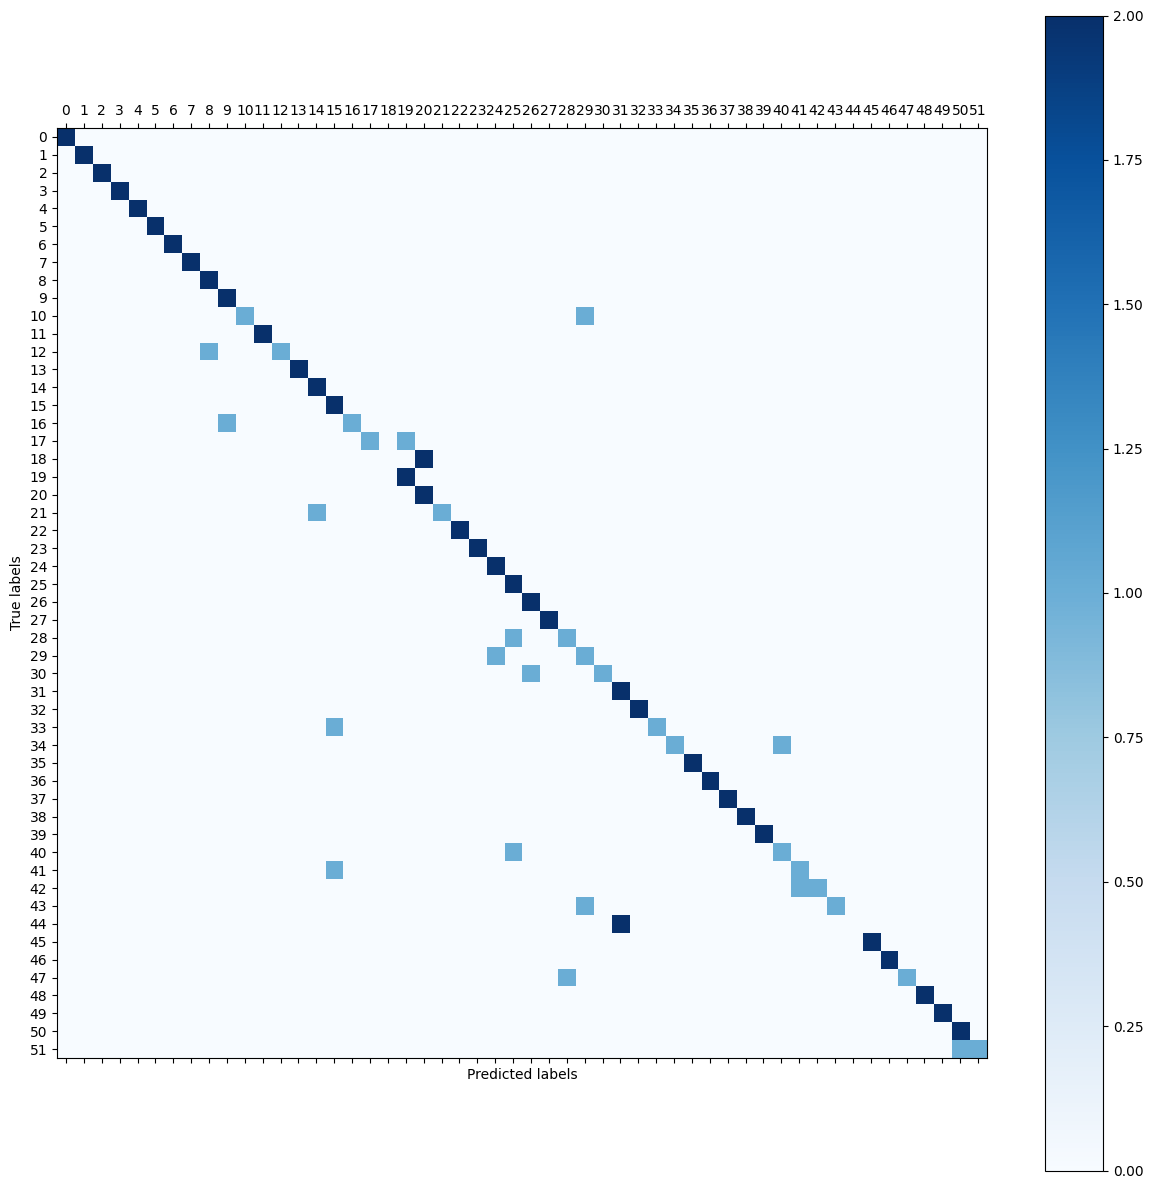

In [ ]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test.T, y_pred)

# Create a larger plot
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the size here

# Display confusion matrix as a heatmap without numbers
cax = ax.matshow(cm, cmap='Blues')  # Use 'Blues' color map or any other you prefer

# Add color bar
plt.colorbar(cax)

# Label the axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Set tick marks (optional: adjust depending on the number of classes)
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

# Show the plot
plt.show()

In [ ]:
# Print success cases and failure cases
true_idx = []
fail_idx = []
for i in range(len(y_pred)):
  if y_test.T[i] == y_pred[i]:
    true_idx.append(i)
  else:
    fail_idx.append(i)

print('Success Cases')
print(true_idx)

print('Failure Cases')
print(fail_idx)

Success Cases
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 59, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 83, 85, 87, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102]
Failure Cases
[21, 24, 32, 35, 36, 37, 43, 57, 58, 60, 67, 69, 81, 82, 84, 86, 88, 89, 94, 103]


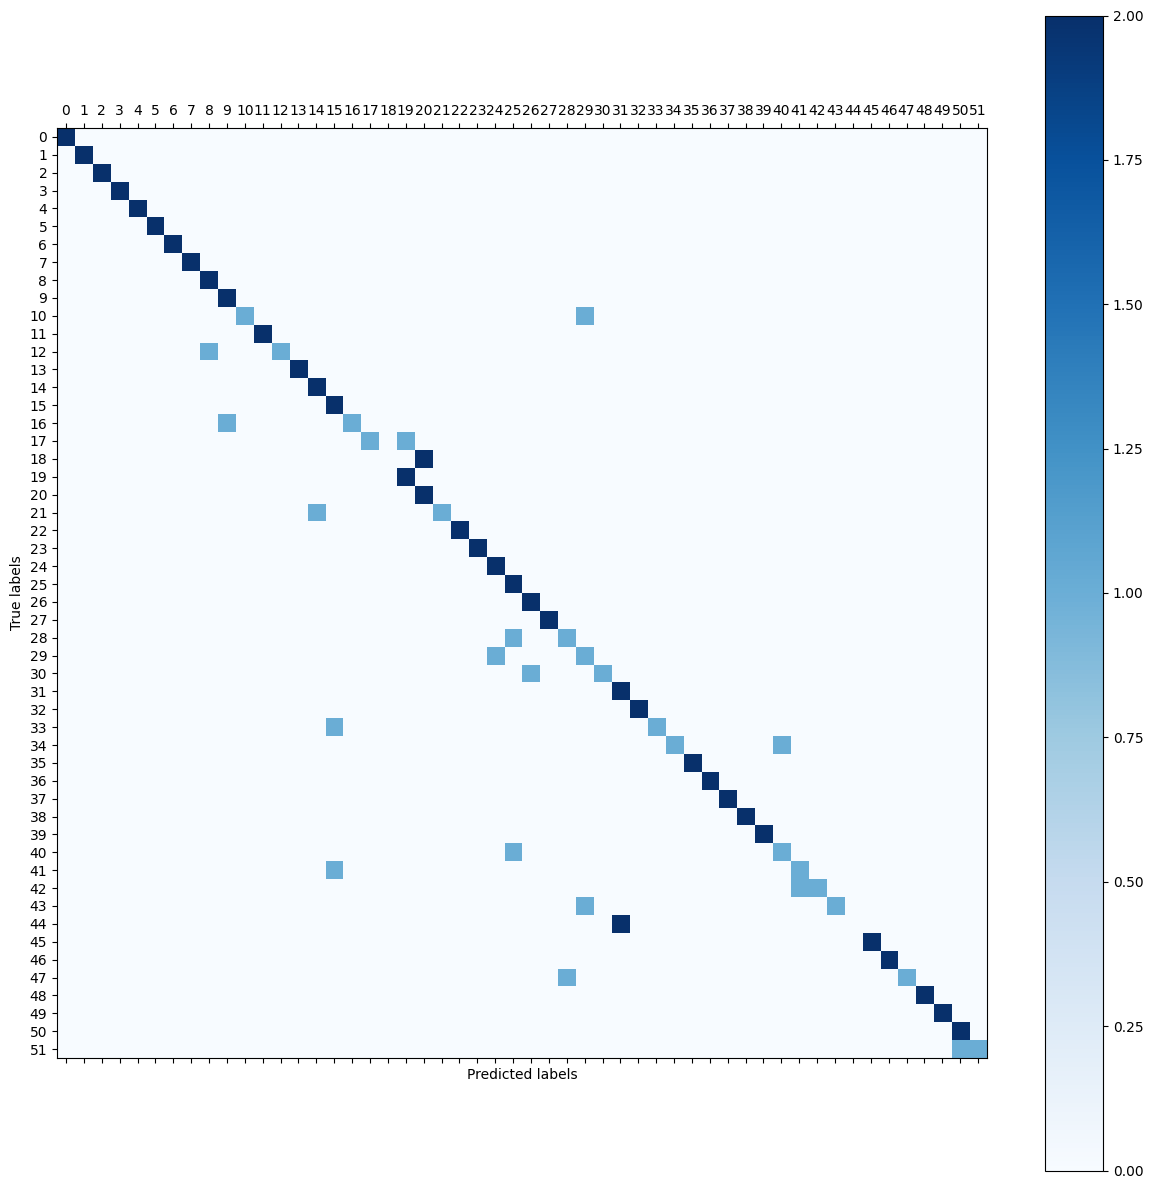

In [ ]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test.T, y_pred)

# Create a larger plot
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the size here

# Display confusion matrix as a heatmap without numbers
cax = ax.matshow(cm, cmap='Blues')  # Use 'Blues' color map or any other you prefer

# Add color bar
plt.colorbar(cax)

# Label the axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Set tick marks (optional: adjust depending on the number of classes)
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

# Show the plot
plt.show()


### **1. (b) Alternative method**

PCA library 사용

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from memory_profiler import memory_usage
import time

images_per_class = 8
num_classes = 52

class_pca_models = {}

# Get PCA results for each class
for i in range(num_classes):
    x_class = x_train[:, i * images_per_class : (i + 1) * images_per_class]
    x_class_bar = np.average(x_class, axis=1).reshape(-1,1)
    x_train_phi = x_class - x_class_bar

    pca = PCA(n_components=5)
    pca.fit(x_train_phi.T)

    # label starts from 1 not 0 -> i+1
    class_pca_models[i+1] = (pca, x_class_bar)

def reconstruction_error(test_image, pca_model, x_class_bar):
    # step 1. normalize
    x_test_phi = test_image - x_class_bar

    # step 2. apply pca to test data
    W_test = pca_model.transform(x_test_phi.T).T

    # step 3. get eigenvectors from pca model
    U = pca_model.components_.T

    # step 4. reconstruction
    # x_test_rec = x_class_bar + pca_model.inverse_transform(W_test.T).T
    x_test_rec = x_class_bar + np.matmul(U, W_test)

    # step 5. calculate error
    error = np.mean(np.abs(test_image - x_test_rec))
    # error = np.mean((test_image - x_test_rec)**2)

    return error, x_test_rec


def classify_test_image(test_image):
    min_error = float('inf')
    best_class = -1

    for class_label, (pca_model, x_class_bar) in class_pca_models.items():
        error, x_test_rec = reconstruction_error(test_image, pca_model, x_class_bar)

        if error < min_error:
            min_error = error
            best_class = class_label

    # plt.imshow(np.reshape(x_test_rec[:,1],(46,56)).T, cmap = 'gist_gray')
    # print(error)
    return best_class

# Measure memory usage and execution time
start_mem = memory_usage()[0]
start_time = time.time()        # Start time

# calculate errors
y_pred = np.zeros(shape=(x_test.shape[1], 1))

for i in range(x_test.shape[1]):
    y_pred[i] = classify_test_image(x_test[:, i].reshape(-1,1))

accuracy = accuracy_score(y_test.T, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# End of memory usage
end_mem = memory_usage()[0]     # End memory
end_time = time.time()           # End time

# Memory and time results
print(f"Memory Usage: {end_mem - start_mem:.8f} MiB")
print(f"Execution Time: {end_time - start_time:.2f} seconds")

Accuracy: 80.77%
Memory Usage: 0.00000000 MiB
Execution Time: 4.44 seconds


x_bar 안 구하고 scaler 사용하는 방법! -> 그냥 결과 동일한지 보려고 한 코드 -> 최종 버전에서는 필요 없음

In [21]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

images_per_class = 8
num_classes = 52

class_pca_models = {}

# Get PCA results for each class
for i in range(num_classes):
  x_class = x_train[:, i * images_per_class : (i + 1) * images_per_class]
  scaler = StandardScaler(with_std=False)
  scaler.fit(x_class.T)
  x_class_scaled = scaler.transform(x_class.T).T

  pca = PCA(n_components=5)
  pca.fit(x_class_scaled.T)

  # label starts from 1 not 0 -> i+1
  class_pca_models[i+1] = (pca, scaler)

def reconstruction_error(test_image, pca_model, scaler):
    # step 1. normalize
    x_test_scaled = scaler.transform(test_image.T).T

    # step 2. apply pca to test data
    W_test = pca_model.transform(x_test_scaled.T).T

    # step 3. get eigenvectors from pca model
    # U = pca_model.components_.T

    # step 4. reconstruction
    # x_test_rec = x_class_bar + np.matmul(U, W_test)
    x_test_rec = pca_model.inverse_transform(W_test.T).T
    x_test_rec = scaler.inverse_transform(x_test_rec.T).T

    # step 5. calculate error
    error = np.mean(np.abs(test_image - x_test_rec))
    # error = np.mean((test_image - x_test_rec)**2)

    return error, x_test_rec


def classify_test_image(test_image):
    min_error = float('inf')
    best_class = -1

    for class_label, (pca_model, scaler) in class_pca_models.items():
        error, x_test_rec = reconstruction_error(test_image, pca_model, scaler)

        if error < min_error:
            min_error = error
            best_class = class_label

    # plt.imshow(np.reshape(x_test_rec[:,1],(46,56)).T, cmap = 'gist_gray')
    # print(error)
    return best_class


# calculate errors
y_pred = np.zeros(shape=(x_test.shape[1], 1))

for i in range(x_test.shape[1]):
    y_pred[i] = classify_test_image(x_test[:, i].reshape(-1,1))

accuracy = accuracy_score(y_test.T, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.77%


In [22]:
# Print success and failure cases
true_idx = []
fail_idx = []
for i in range(len(y_pred)):
  if y_test.T[i] == y_pred[i]:
    true_idx.append(i)
  else:
    fail_idx.append(i)

print('Success Cases')
print(true_idx)

print('Failure Cases')
print(fail_idx)

Success Cases
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 28, 29, 30, 31, 33, 34, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 59, 61, 62, 63, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 83, 85, 87, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102]
Failure Cases
[21, 24, 32, 35, 36, 37, 43, 57, 58, 60, 67, 69, 81, 82, 84, 86, 88, 89, 94, 103]


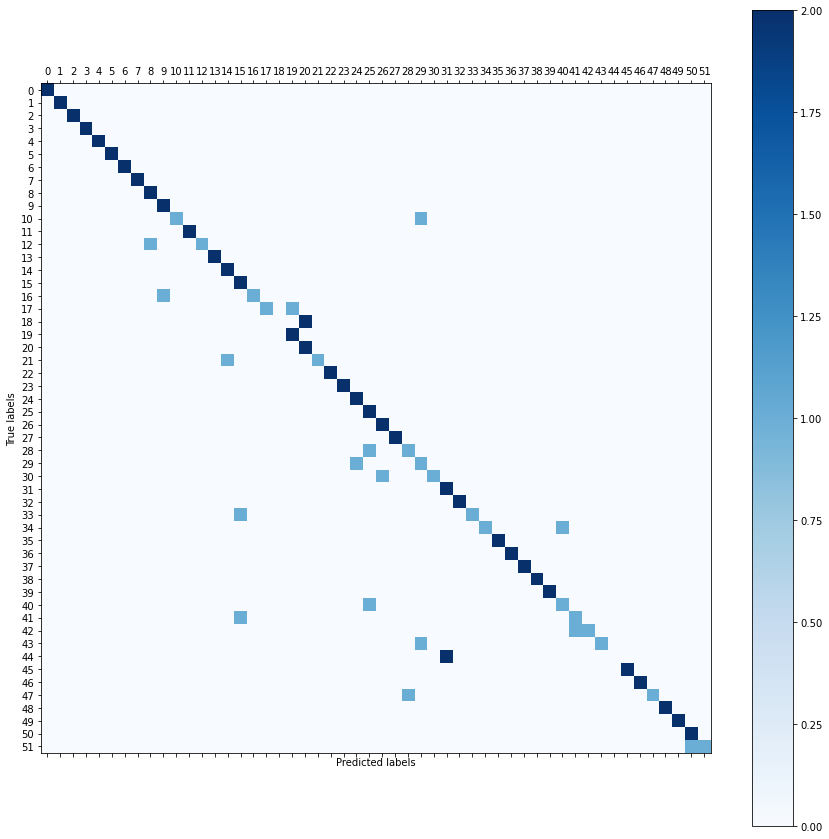

In [23]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test.T, y_pred)

# Create a larger plot
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the size here

# Display confusion matrix as a heatmap without numbers
cax = ax.matshow(cm, cmap='Blues')  # Use 'Blues' color map or any other you prefer

# Add color bar
plt.colorbar(cax)

# Label the axes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Set tick marks (optional: adjust depending on the number of classes)
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

# Show the plot
plt.show()


## **2. Incremental PCA**

In [24]:
# Spliting training dataset into 4 subgroups

x_sub1, x_sub2, x_sub3, x_sub4 = [], [], [], []
y_sub1, y_sub2, y_sub3, y_sub4 = [], [], [], []

n_classes = 52
images_per_class = 8

for i in range(n_classes):
  x_sub1.append(x_train[:,i*images_per_class :i*images_per_class + 2])
  x_sub2.append(x_train[:,i*images_per_class+2 :i*images_per_class + 4])
  x_sub3.append(x_train[:,i*images_per_class+4 :i*images_per_class + 6])
  x_sub4.append(x_train[:,i*images_per_class+6 :i*images_per_class + 8])

  y_sub1.append(y_train[:,i*images_per_class :i*images_per_class + 2])
  y_sub2.append(y_train[:,i*images_per_class+2 :i*images_per_class + 4])
  y_sub3.append(y_train[:,i*images_per_class+4 :i*images_per_class + 6])
  y_sub4.append(y_train[:,i*images_per_class+6 :i*images_per_class + 8])

x_sub1, x_sub2, x_sub3, x_sub4 = np.hstack(x_sub1), np.hstack(x_sub2), np.hstack(x_sub3), np.hstack(x_sub4)
y_sub1, y_sub2, y_sub3, y_sub4 = np.hstack(y_sub1), np.hstack(y_sub2), np.hstack(y_sub3), np.hstack(y_sub4)

normalize 없이 한 경우

In [25]:
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from memory_profiler import memory_usage
import time

# Start of memory and runtime --------------------------------------------------------------
start_mem = memory_usage()[0]
start_time = time.time()

# Step 1: Initialize Incremental PCA
ipca = IncrementalPCA(n_components = 5)

# Step 2: Fit Incremental PCA on training subsets
for subset in [x_sub1.T, x_sub2.T, x_sub3.T, x_sub4.T]:
    ipca.partial_fit(subset)

# End of memory and runtime
end_mem = memory_usage()[0]
end_time = time.time()

# Step 3: Transform training subsets
W_train_sub1 = ipca.transform(x_sub1.T).T
W_train_sub2 = ipca.transform(x_sub2.T).T
W_train_sub3 = ipca.transform(x_sub3.T).T
W_train_sub4 = ipca.transform(x_sub4.T).T

# Optionally combine transformed training data if needed
W_train = np.vstack((W_train_sub1.T, W_train_sub2.T, W_train_sub3.T, W_train_sub4.T))

# Step 4: Fit a classifier (e.g., k-NN) on the transformed training data
nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
# You may need to combine y_train corresponding to each subset for training
y_train_combined = np.concatenate([y_sub1.T, y_sub2.T, y_sub3.T, y_sub4.T])  # Combine true labels

nn.fit(W_train, y_train_combined)

# Step 5: Transform the test data
W_test = ipca.transform(x_test.T).T

# Step 6: Predict using the classifier
y_pred = nn.predict(W_test.T)

# Step 7: Calculate accuracy
accuracy = accuracy_score(y_test.T, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Memory and time results
print(f"Memory Usage: {end_mem - start_mem:.8f} MiB")
print(f"Execution Time: {end_time - start_time:.2f} seconds")

Accuracy: 38.46%
Memory Usage: 22.47265625 MiB
Execution Time: 0.21 seconds


/Users/jiwooshin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
